## Анализ товарного ассортимента

Задача проекта - анализ ассортимента товаров интернет-магазина «Пока все ещё тут». Анализ должен включать:
* исследовательский анализ данных;
* анализ ассортимента;
* проверку статистических гипотез.

Цель проекта - определить, какие товары входят в основной и дполнительный ассортимент, чтобы заказчик мог оптимизировать свои закупки.

Все необходимые данные хранятся в файле `ecommerce_dataset.csv`.

Датасет включает следующие колонки:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

### Материалы:
* [Презентация](https://disk.yandex.ru/i/yShLNBoVkIoqaA)
* [Дашборд](https://public.tableau.com/views/-_16251703147780/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link) (Набор №2)

### План проекта
#### 1. [Предобработка данных](#data)
#### 2. [Исследовательский анализ данных](#eda)
#### 3. [Категоризация товаров](#category)
#### 4. [Деление товаров на ассортименты](#assor)
#### 5. [Проверка гипотез](#check)
#### 6. [Вывод](#conclusion)

Загрузим необходимые библиотеки и сам датасет

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/ecommerce_dataset.csv')

### Предобработка данных
<a id="data"></a>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Пропусков нет.

In [4]:
df.duplicated().sum()

0

Полных дубликатов нет.

In [5]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Столбец с датой выглядит подозрительно. Посмотрим, какие ещё значения он принимает.

In [6]:
df['date'].value_counts().head(50)

2019042716    51
2019042421    44
2019060722    42
2019051219    39
2019051315    36
2019050216    36
2019051411    33
2019060509    33
2019060419    32
2019060608    30
2019060808    30
2019051309    30
2019042913    29
2019060418    29
2019053122    29
2019060716    29
2019051320    27
2019052913    27
2019070917    26
2019051508    25
2019071009    25
2019070514    24
2018100211    22
2018102613    21
2019041014    20
2019051622    20
2019032812    19
2019050711    19
2019030113    18
2018120311    18
2019052110    18
2018111014    18
2019061621    18
2019053022    17
2019032914    17
2019041916    17
2019060510    17
2019040212    17
2019050813    16
2019022514    16
2019030415    15
2018110408    15
2019051119    15
2018102723    15
2019060514    15
2019051815    15
2019060411    14
2019041616    14
2018102917    14
2019092121    14
Name: date, dtype: int64

Первые 4 цифры - год, следующие пары цифр не больше 12 (месяц), не больше 31 (день) и не больше 24 (час) соответственно. Переводим дату в нужный формат.

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [8]:
print('В датасете собраны данные с {} по {}'.format(df['date'].min(), df['date'].max()))

В датасете собраны данные с 2018-10-01 00:00:00 по 2019-10-31 16:00:00


То есть чуть больше года - почти 13 месяцев.

Переведём наименования продукции в нижний регистр - в дальнейшем это упростит категоризацию, т.к. можно будет не учитывать Caps Lock.

In [9]:
df['product'] = df['product'].str.lower()

Добавим столбец с суммой покупки, перемножив `quantity` и `price`.

In [10]:
df['revenue'] = df['quantity'] * df['price']

Предобработка данных завершена, переходим к исследовательскому анализу данных.

### Исследовательский анализ данных
<a id="eda"></a>

In [11]:
df.describe()

,order_id,quantity,price,revenue
count,6737.000000,6737.000000,6737.000000,6737.000000
mean,43128.948345,2.501559,462.028499,720.094998
std,27899.414662,15.266478,871.296064,8352.100591
min,12624.000000,1.000000,9.000000,9.000000
25%,14827.000000,1.000000,101.000000,120.000000
50%,68503.000000,1.000000,135.000000,162.000000
75%,70504.000000,1.000000,398.000000,600.000000
max,73164.000000,1000.000000,14917.000000,675000.000000


id покупок нас не интересуют, отрицательных цен и количеств товара не выявлено. Но уже заметны аномалии максимальных значений: какой-то оптовик закупил разом 1000 единиц товара (одного товара, кстати!) и какой-то товар стоил почти 15 тысяч.

In [12]:
df.sort_values('price',ascending = False)

,date,customer_id,order_id,product,quantity,price,revenue
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917.0,14917.0
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,сумка-тележка хозяйственная andersen royal sho...,1,8737.0,8737.0
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,сумка-тележка хозяйственная andersen alu star ...,1,8437.0,8437.0
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077.0,8077.0
6629,2019-10-16 15:00:00,d5584388-ffbe-42fd-a746-a98828ec919f,72992,стремянка 7 ступенчатая hailo 8040-707 xxl 13 ...,1,7724.0,7724.0
...,...,...,...,...,...,...,...
2169,2019-03-04 15:00:00,0f47231c-3a68-404a-88f7-08a4a172c17f,14559,"укроп обильнолистный 3,0 г 4660010772562",1,10.0,10.0
1078,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"львиный зев волшебный ковер 0,05 г 4660010779639",1,9.0,9.0
1069,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"алиссум (лобулярия) снежные одежды 0,2 г 46500...",2,9.0,18.0
5642,2019-07-03 22:00:00,1ec1ad59-a29b-4949-929d-f4fc4fe14758,14887,"алиссум (лобулярия) снежные одежды 0,2 г 46500...",1,9.0,9.0


Да, сушилки на самом деле бывают настолько дорогими.

In [13]:
df[['product','quantity']].sort_values('quantity', ascending = False).head(20)

,product,quantity
5456,"вантуз с деревянной ручкой d14 см красный, bur...",1000
5071,вешалки мягкие для деликатных вещей 3 шт шоколад,334
3961,муляж яблоко 9 см красное,300
1158,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200
568,муляж яблоко 9 см красное,170
211,"крепеж для пружины дверной, 1107055",150
212,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150
267,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150
2431,плечики пластмассовые размер 52 - 54 тула 1205158,150
266,"крепеж для пружины дверной, 1107055",150


Тысяча вантузов! Можно поверить в какое угодно количество муляжей яблок и вешалок в одном заказе, но тысяча вантузов - это реально чересчур. 334 вешалки могли потребоваться для гардероба какого-нибудь театра, муляжи яблок и дверные пружины покупают сотнями, но тысяча вантузов - это реально за гранью.

Удалим эту позицию, поскольку далее мы будем делить товар на основной и дополнительный в том числе, исходя из среднего количества при покупке и объёма проданного товара. Тысяча вантузов реально исказит всю картину.

In [14]:
df.drop(df.loc[df['quantity']==1000].index, inplace=True)

Посмотрим на распределение значений по количеству товаров и стоимости покупок.

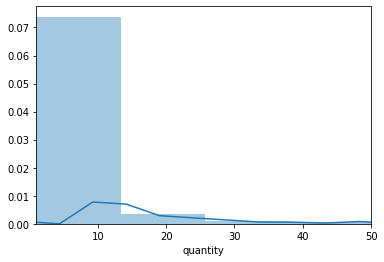

In [15]:
plt.xlim(1,50)
sns.distplot(df.groupby('product')['quantity'].sum(), bins = 50)

Абсолютное большинство товаров продаётся не более, чем по 10 штук.

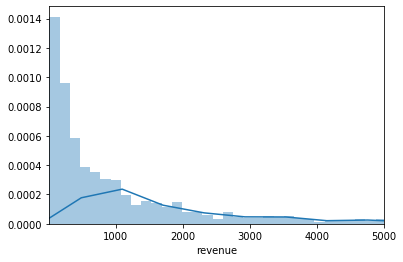

In [16]:
plt.xlim(1,5000)
sns.distplot(df.groupby('product')['revenue'].sum(), bins = 500)

Абсолютное большинство покупок не дороже 1000 руб., уже с учётом количества товаров.

In [17]:
df.groupby(['customer_id', 'order_id', 'product']).count().sort_values('date', ascending=False).head()

date  \
customer_id                          order_id product                                                    
1d6c8c1f-a799-4418-9af2-1ded47d7a85c 14833    рассада патиссона сорт диск, кассета по 6шт           74   
                                              рассада кабачка сорт зебра кассета 6 шт e6            74   
                                              тагетис крупноцветковый рассада однолетних цвет...    74   
                                              рассада патиссона сорт нло белый, кассета по 6шт      74   
                                              рассада огурца сорт каролина кассета 6 шт e6          74   

                                                                                                  quantity  \
customer_id                          order_id product                                                        
1d6c8c1f-a799-4418-9af2-1ded47d7a85c 14833    рассада патиссона сорт диск, кассета по 6шт               74   
                                              рассада кабачка сорт зебра кассета 6 шт e6                74   
                                              тагетис крупноцветковый рассада однолетних цвет...        74   
                                              рассада патиссона сорт нло белый, кассета по 6шт          74   
                                              рассада огурца сорт каролина кассета 6 шт e6              74   

                                                                                                  price  \
customer_id                          order_id product                                                     
1d6c8c1f-a799-4418-9af2-1ded47d7a85c 14833    рассада патиссона сорт диск, кассета по 6шт            74   
                                              рассада кабачка сорт зебра кассета 6 шт e6             74   
                                              тагетис крупноцветковый рассада однолетних цвет...     74   
                                              рассада патиссона сорт нло белый, кассета по 6шт       74   
                                              рассада огурца сорт каролина кассета 6 шт e6           74   

                                                                                                  revenue  
customer_id                          order_id product                                                      
1d6c8c1f-a799-4418-9af2-1ded47d7a85c 14833    рассада патиссона сорт диск, кассета по 6шт              74  
                                              рассада кабачка сорт зебра кассета 6 шт e6               74  
                                              тагетис крупноцветковый рассада однолетних цвет...       74  
                                              рассада патиссона сорт нло белый, кассета по 6шт         74  
                                              рассада огурца сорт каролина кассета 6 шт e6             74

В датасете обнаружены повторения товаров в рамках одной покупки: вероятно, дело в отслеживании статуса. Чтобы избежать таких повторов, будем искать их в группе столбцов, а не во всём датафрейме, оставляя при этом последнее упоминание товара в заказе - вероятно оно и обозначает покупку.

In [18]:
df.drop_duplicates(subset=['customer_id', 'order_id', 'product'], keep = 'last', inplace = True)

Проверка.

In [19]:
df.groupby(['customer_id', 'order_id', 'product']).count().sort_values('date', ascending=False).head()

date  \
customer_id                          order_id product                                                    
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    пеларгония зональная диам. 12 см темнорозовая п...     1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    алиссум рассада однолетних цветов в кассете по ...     1   
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258    пеларгония розебудная red pandora укорененный ч...     1   
                                     71341    калла крупноцветковая малиновая                        1   
b16a52b7-499b-4be8-9220-19076ed22bc9 70627    сумка-тележка хозяйственная rolser mountain чер...     1   

                                                                                                  quantity  \
customer_id                          order_id product                                                        
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    пеларгония зональная диам. 12 см темнорозовая п...         1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    алиссум рассада однолетних цветов в кассете по ...         1   
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258    пеларгония розебудная red pandora укорененный ч...         1   
                                     71341    калла крупноцветковая малиновая                            1   
b16a52b7-499b-4be8-9220-19076ed22bc9 70627    сумка-тележка хозяйственная rolser mountain чер...         1   

                                                                                                  price  \
customer_id                          order_id product                                                     
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    пеларгония зональная диам. 12 см темнорозовая п...      1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    алиссум рассада однолетних цветов в кассете по ...      1   
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258    пеларгония розебудная red pandora укорененный ч...      1   
                                     71341    калла крупноцветковая малиновая                         1   
b16a52b7-499b-4be8-9220-19076ed22bc9 70627    сумка-тележка хозяйственная rolser mountain чер...      1   

                                                                                                  revenue  
customer_id                          order_id product                                                      
000d6849-084e-4d9f-ac03-37174eaf60c4 14943    пеларгония зональная диам. 12 см темнорозовая п...        1  
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722    алиссум рассада однолетних цветов в кассете по ...        1  
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258    пеларгония розебудная red pandora укорененный ч...        1  
                                     71341    калла крупноцветковая малиновая                           1  
b16a52b7-499b-4be8-9220-19076ed22bc9 70627    сумка-тележка хозяйственная rolser mountain чер...        1

Дубликаты удалены!

### Категоризация товаров
<a id="category"></a>

Прежде чем делить товары на основной и дополнительный ассортимент, целесообразно выделить их укрупнённые категории, исходя из названий. Сколько всего товаров в нашем распоряжении?

In [20]:
df['product'].nunique()

2340

2340 наименований. Сначала построим сводную таблицу, т.к. один и тот же товар может присутствовать в разных покупках, а затем добавим туда столбец, где будем записывать категории.

In [21]:
df_pivot = pd.pivot_table(df, index = 'product', values = 'revenue', aggfunc = 'sum').reset_index()
df_pivot['category'] = df_pivot['product']

Теперь самый трудозатратный процесс - отнесение товаров к разным категориям по ключевым словам.

In [22]:
#сумки-тедежки
df_pivot.loc[df_pivot['product'].str.contains('сумк|тележк'), 'category'] = 'сумки'

#кухонная утварь
df_pivot.loc[df_pivot['product'].str
       .contains('салфет|блюд|салатник|банк|кувшин|миск|тарелк|скатерт|нож|чашк|кружк|кастрюл|посуд'), 
       'category'] = 'кухонная утварь'

#далее растения
df_pivot.loc[df_pivot['product'].str
             .contains('пеларгония|растение|махровая|зональная|ампельная|циперус|тюльпан|комнатн|огурец|трав|настурц'), 'category'] = 'растения'

#снова растения
df_pivot.loc[df_pivot['product'].str
       .contains('эвкалипт|лобелия|вербена|цвето|цветк|вербейник|дерево|калибрахоа|базилик|мята|томат|лаванд|роза|арбуз|в горшк'), 
       'category'] = 'растения'

#снова растения
df_pivot.loc[df_pivot['product'].str
       .contains('кориандр|гортенз|тимья|розмарин|петрушк|звероб|патисс|салат|кабач|капуст|дын|гиац|хриз|огур|бегон'), 
       'category'] = 'растения'

#хозтовары
df_pivot.loc[df_pivot['product'].str
       .contains('термометр|сушилк|доск|ёрш|корыто|таз|стремян|лестниц|щетк|контейн|швабр|перчат|корзин|ерш|короб|ведр|мкост'), 
       'category'] = 'хозтовары'

#ещё хозтовары
df_pivot.loc[df_pivot['product'].str
       .contains('веник|окон|вантуз|прищеп|дозатор|шнур|крюч|петл|обувниц|пруж|колк|лопатк|кипятилн|мойк|кипятильн|подрукавн|пробк'), 
       'category'] = 'хозтовары'

#предметы интерьера
df_pivot.loc[df_pivot['product'].str.contains('карниз|ковр|сиден|штор|оконн|полк|штанг|комод|ковер|картин'), 'category'] = 'интерьер'

#кухонная утварь
df_pivot.loc[df_pivot['product'].str
       .contains('варк|терк|бокал|салфет|блюд|салатник|банк|кувшин|миск|тарелк|скатерт|нож|чашк|кружк|крышк|выпечк|ложк|термос|фужер|чайн|хлебниц|посуд'), 
       'category'] = 'кухонная утварь'

#товары для одежды
df_pivot.loc[df_pivot['product'].str.contains('одежд|чехол|вешал|плечик'), 'category'] = 'товары для одежды'

#бытовая химия
df_pivot.loc[df_pivot['product'].str.contains('мыло|пена|паста|кондиционер|шампун|крем|хлор|чист'), 'category'] = 'бытовая химия'

#одежда, бельё, текстиль
df_pivot.loc[df_pivot['product'].str.contains('халат|полотен|покрывал|наматрас|простын|белье|белья'), 'category'] = 'текстиль'

#рассада
df_pivot.loc[df_pivot['product'].str.contains('рассад'), 'category'] = 'рассада'

#муляжи
df_pivot.loc[df_pivot['product'].str.contains('муляж|искусственн'), 'category'] = 'муляжи'

#всё остальное - в другое
categories = df_pivot['category'].value_counts().head(10).index.tolist()
df_pivot.loc[~df_pivot['category'].isin(categories), 'category'] = 'другое'

In [23]:
df_pivot['category'].value_counts()

растения             428
другое               407
кухонная утварь      286
хозтовары            286
рассада              221
текстиль             169
интерьер             166
муляжи               129
товары для одежды    111
сумки                105
бытовая химия         32
Name: category, dtype: int64

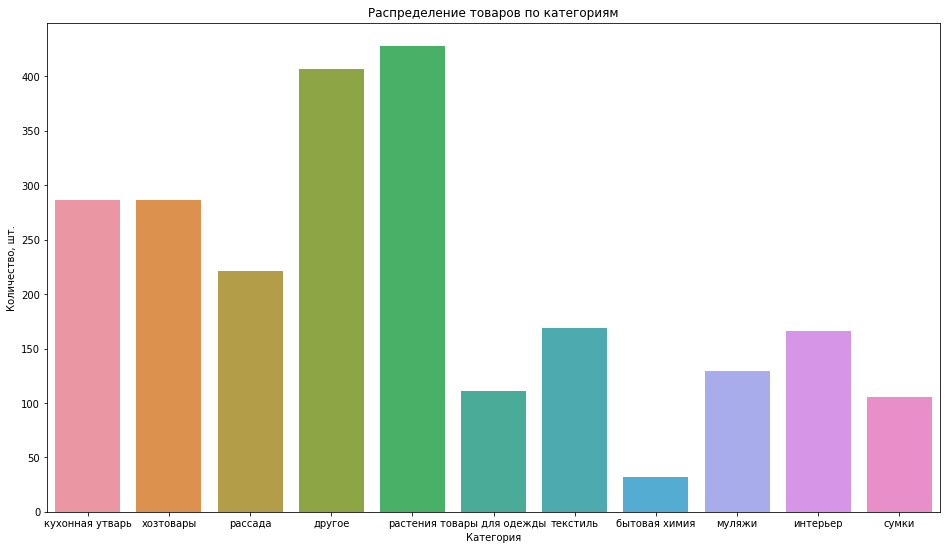

In [24]:
plt.figure(figsize=(16,9))
sns.countplot(data = df_pivot, x = 'category')
plt.title('Распределение товаров по категориям')
plt.ylabel('Количество, шт.')
plt.xlabel('Категория')
plt.show()

Категория "другое" всё равно получилась довольно многочисленной, но мы рассортировали 80% товаров!

### Деление товаров на ассортименты
<a id="assor"></a>

После категоризации товаров необходимо разделить ассортимент на основной и дополнительный. Важнейшим критерием товара для магазина является выручка, которую тот может генерировать. Тут уместно вспомнить принцип Парето - 20% товаров производят 80% выручки (в данной интерпретации этого принципа). Поэтому будет уместно поделить товары на два ассортимента по соотношению: 20% наиболее прибыльных и 80% наименее прибыльных.

Для интереса посмотрим на суммарную выручку товаров разных категорий.

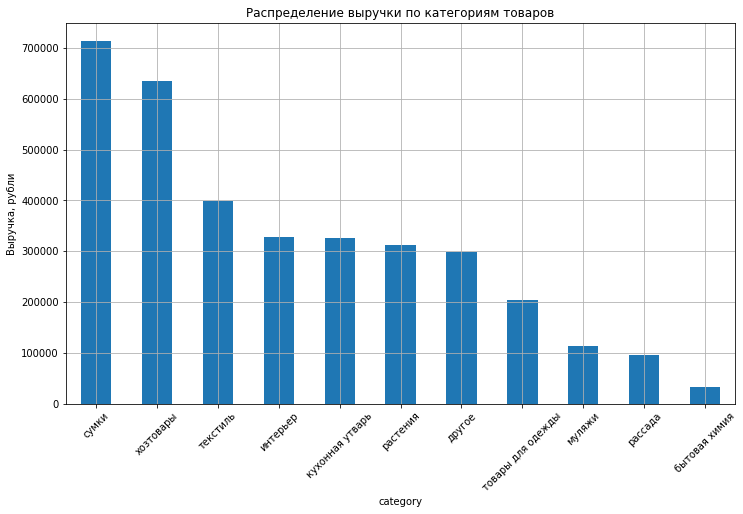

In [25]:
(df_pivot.pivot_table(index = 'category', values = 'revenue', aggfunc = 'sum')
         .sort_values(by = 'revenue', ascending = False)
         .plot(kind = 'bar', grid = True, figsize = (12, 7), legend = False, rot = 45)
)
plt.title('Распределение выручки по категориям товаров')
plt.ylabel('Выручка, рубли')
plt.show()

Сумки и хозтовары продаются лучше всего. Наверняка среди этих категорий будет много товаров из основного ассортимента.

Разделим же товары на два ассортимента. 20% наименований с наибольшей выручкой станут основный ассортиментом, а 80% остальных - дополнительным.

In [26]:
#пишем функцию
def group(x):
        if x < df_pivot['revenue'].quantile(0.8):
            return 'дополнительный'
        else:
            return 'основной'
#применяем к датасету
df_pivot['group'] = df_pivot['revenue'].apply(lambda x: group(x))

Интересно, а как распределяется выручка между ассортиментами?

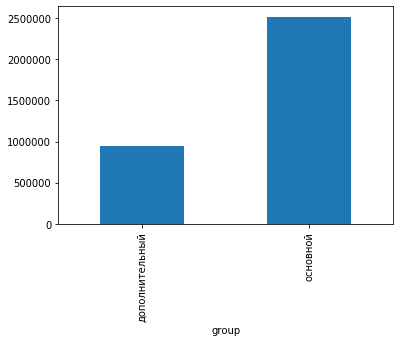

In [27]:
df_pivot.groupby('group')['revenue'].sum().plot(kind = 'bar')

Соотношение по итоговой выручке между основным и дополнительным ассортиментами получилось не 80/20, а 75/25

Посмотрим на количество товаров каждой категории, попавших в основной и дополнительный ассортимент.
<a id="1"></a>

In [28]:
df_pivot.pivot_table(index = 'category', columns = 'group', values = 'revenue', aggfunc = 'count')

group,дополнительный,основной
category,,
бытовая химия,28,4
другое,372,35
интерьер,100,66
кухонная утварь,243,43
муляжи,122,7
рассада,216,5
растения,390,38
сумки,20,85
текстиль,102,67


Основной ассортимент представлен в основном хозтоварами, сумками, текстилём и товарами для интерьера.
Дополнительный - рассадой, растениями и прочими товарами.

Соотношение по итоговой выручке между основным и дополнительным ассортиментами получилось не 80/20, а 75/25.

Посмотрим на соотношение ассортиментов внутри каждой категории товаров.

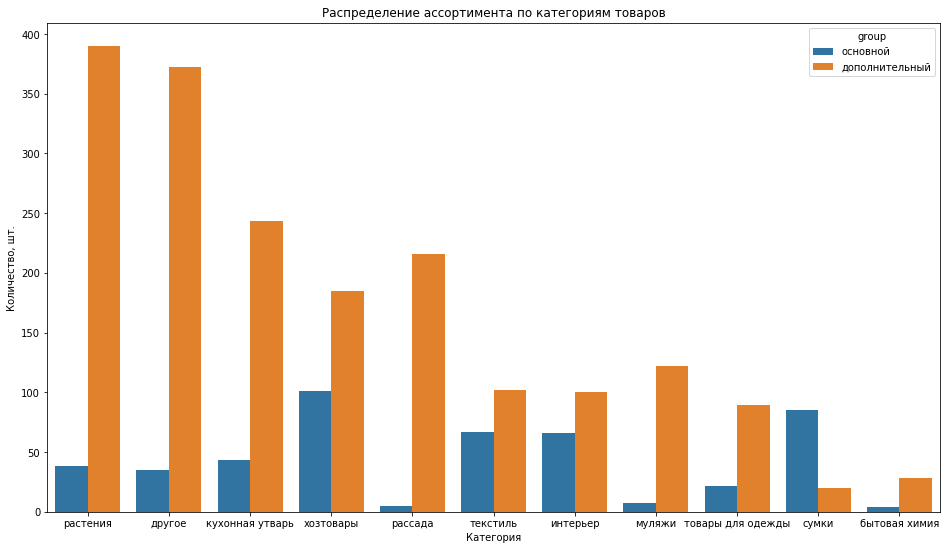

In [29]:
plt.figure(figsize=(16,9))
categories = df_pivot['category'].value_counts().head(11).index.tolist()
sns.countplot(data = df_pivot, x = 'category', hue = 'group', order = categories)
plt.title('Распределение ассортимента по категориям товаров')
plt.ylabel('Количество, шт.')
plt.xlabel('Категория')
plt.show()

Сумки - ключевой ассортимент этого магазина, большинство товаров этой категории относится к основному ассортименту. На втором месте по этому соотношению халаты-полотенца (категория "текстиль"), на третьем - хозтовары.

Подавляющее большинство товаров категорий "рассада" и "муляжи" генерируют очень мало прибыли.

Посмотрим на то, какие товары попали в основной и дополнительный ассортимент.

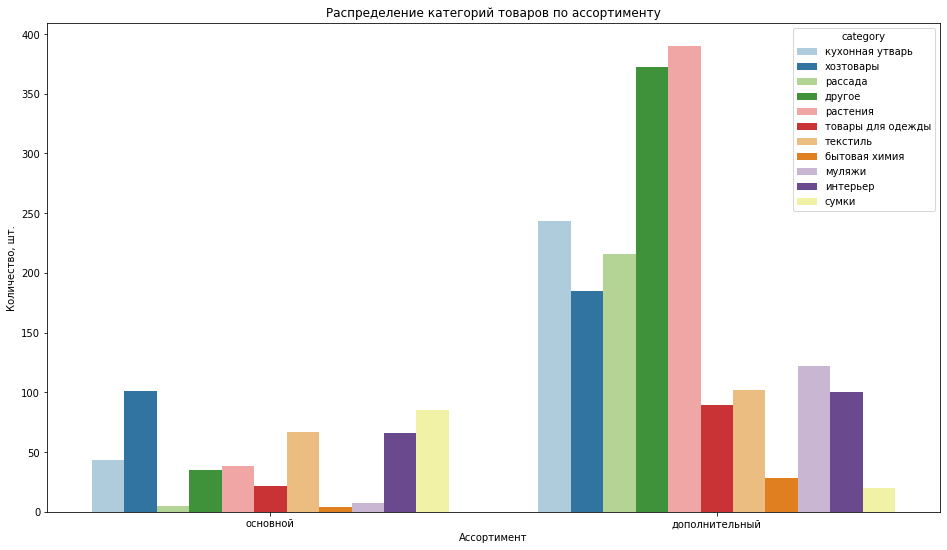

In [30]:
plt.figure(figsize=(16,9))
sns.countplot(data = df_pivot, x = 'group', hue = 'category', palette = 'Paired')
plt.title('Распределение категорий товаров по ассортименту')
plt.ylabel('Количество, шт.')
plt.xlabel('Ассортимент')
plt.show()

Как и отметили ранее, основной ассортимент представлен в основном хозтоварами, сумками, текстилём и товарами для интерьера. Дополнительный - рассадой, растениями и прочими товарами.

### Проверка гипотез
<a id="check"></a>

При распределении товаров по категориям выявил, что в "другое" упало очень много названий растений - с ними тяжело работать из-за большого количества разных экзотических названий.

**Первая гипотеза - средняя выручка товаров категорий "растения" и "другое" одинакова.**

Категории "бельё, текстиль" и "интерьер" тоже демонстрируют похожие значения по количеству товаров и общей выручке.

**Вторая гипотеза - средняя выручка товаров категорий "текстиль" и "интерьер" различается.**

Вытащим интересующие нас данные.

In [31]:
plants = df_pivot.loc[df_pivot['category'] == 'растения', 'revenue']
other = df_pivot.loc[df_pivot['category'] == 'другое', 'revenue']

textile = df_pivot.loc[df_pivot['category'] == 'текстиль', 'revenue']
interior = df_pivot.loc[df_pivot['category'] == 'интерьер', 'revenue']

Нормализуем данные.

In [32]:
scaler = MinMaxScaler()
for element in [plants, other, textile, interior]:
    element = scaler.fit_transform(element.values.reshape(-1, 1))

Приступаем к проверке гипотез. Будем использовать t-Тест, уровень статистической значимости 0,05.
Важное ограничение - необходимо знать, равны ли дисперсии в сравниваемых парах.

In [33]:
alpha = 0.05

print(plants.var(),other.var(),'\n\n',textile.var(),interior.var())

2226548.4095734204 3217286.4583701477 

 19085248.901591998 4890572.802190581


Достаточно разные в обоих случаях.

**Приступаем к проверке первой гипотезы.** Сначала формулируем нулевую гипотезу: средняя выручка товаров категорий "растения" и "другое" одинаковая. Соответственно, альтернативная гипотеза: средняя выручка различается.

In [34]:
results = st.ttest_ind(plants, other, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9805050094912853
Не получилось отвергнуть нулевую гипотезу


Неплохо! Не можем отвергнуть нулевую гипотезу, значит в категории "другое" действительно осталось много растений.

**Приступаем к проверке второй гипотезы.** Сначала формулируем нулевую гипотезу: средняя выручка товаров категорий "текстиль" и "интерьер" одинаковая. Соответственно, альтернативная гипотеза: средняя выручка различается.

In [35]:
results = st.ttest_ind(textile, interior, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3100798980153507
Не получилось отвергнуть нулевую гипотезу


Аналогичный результат! Значит условные шторки и халаты генерируют примерно одинаковую выручку.

### Вывод
<a id="conclusion"></a>

Проанализировали датасет с покупками магазина хозтоваров (и множества других товаров) на предмет отнесения товаров к основному ассортименту и дополнительному. Представлены данные за 13 месяцев.

На этапе предобработки избавились от одной покупки с вантузами - 1000 штук, суммарно на 675 тыс у.е., что составило бы примерно 15% от выручки магазина за 13 месяцев. Одна покупка!

Также были обнаружены дубликаты товаров в рамках одного заказа - это могло произойти из-за разного статуса заказа (создан, оплачен, доставлен и т.д.). Чтобы избежать задвоения выручки по товарам, эти дубликаты пришлось удалить.

Далее, по ключевым словам разделили все товары на следующие категории: растения, рассада, хозтовары, кухонная утварь, бытовая химия, товары для одежды, текстиль, сумки, муляжи, интерьер и другое. Категория "другое" получилась достаточно многочисленной, но удалось рассортировать 80% датасета.

Наибольшую выручку в магазине генерируют сумки, хотя представляют всего 100 позиций из 2300 во всём магазине. На втором месте хозтовары, в аутсайдерах - муляжи и бытовая химия.

Деление товаров на ассортимент (основной и дополнитльный) было решено производить исходя из выручки, производимой ими. Вспомним принцип Парето: согласно ему, 20% товаров должны генерировать 80% выручки и наоборот. Поэтому поделили все товары по объёму выручки: 20% лидеров определили в основной ассортимент, а 80% остальных - в дополнительный. Кстати, соотношение двух категорий по общему объёму выручки составило 3:1 или 75/25, так что принцип Парето допускает погрешности.

Основной ассортимент представлен в основном хозтоварами, сумками, текстилём и товарами для интерьера. Дополнительный - рассадой, растениями и товарами категории "другие".

Также проверили две гипотезы: средняя выручка растений и других одинаковая, а средняя выручка интерьера и текстиля разная. В первом случае не удалось доказать, что выручки отличаются, значит к другим на самом деле попало много растений. Во втором случае также не удалось опровергнуть гипотезу о равенстве двух выборок, значит нельзя утерждать, что товары интерьера и текстиля генерируют разную выручку.